Code for **"Phase Retrieval"** 

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim
from utils.inpainting_utils import *
from utils.utils import *

# Misc. Setup

In [2]:
# Enable GPU usage
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

# Change cwd
directory = "/home/justin/Github/deep-image-prior/"
os.chdir(directory)

# Misc.
PLOT = True
imsize = -1
dim_div_by = 64

# Load Image and Measurement

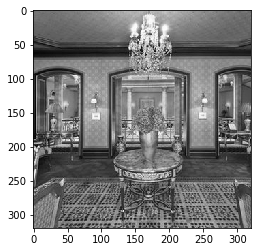

In [9]:
# Set Image
img_type = 'grayscale'
img_path  = 'data/inpainting/vase.png'
_, img_np = get_image(img_path, imsize, img_type)
# img_np = img_np[:,0:64,0:64]
img_var = np_to_torch(img_np, True).type(dtype)

# Print Image
plt.imshow(img_np[0], cmap = 'gray')
directory = './plots/'
filename = directory + 'original.png'
plt.savefig(filename)
plt.show()

# Generate Gaussian Matrix (A)
m = int(float(np.shape(img_np)[1])/2.0)
n = np.shape(img_np)[1]
mu = 0.0
sigma = 0.25

A = mu + sigma*np.random.randn(m,1,n)
A_var = np_to_torch(A, False).type(dtype)

# Set Measurement
measurement = np.tensordot(A,img_np,2)
measurement_var = np_to_torch(measurement, False).type(dtype)
measurement_var = measurement_var.abs()

# Setup

In [4]:
# Optimization Setup
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'
NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet


#--------------------------
# Network Arch. Setup
#--------------------
INPUT = 'meshgrid'
input_depth = 2                   # depth of input noise
output_depth = 1
LR = 0.01                         # learning rate
num_iter = 1300
param_noise = False               # add noise to net params during optimization 
show_every = 100
figsize = 5
reg_noise_std = 0.03              # add noise to net input during optimization

num1 = 5 # 5
num2 = 3 # 3
num3 = 128 # 128

net = skip(input_depth, output_depth, 
           num_channels_down = [num3] * num1,
           num_channels_up   = [num3] * num1,
           num_channels_skip = [0] * num1,  
           upsample_mode='nearest', filter_skip_size=1, filter_size_up=num2, filter_size_down=num2,
           need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)


net = net.type(dtype)
img_dim = img_np.shape[1:]
net_input = get_noise(input_depth, INPUT, img_dim).type(dtype)
#--------------------------

# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

Number of params: 2157697


# Main loop

In [5]:
i = 0

#----------------------------------
def dip_function():

    global i
    
    # Add noise to network parameters / network input
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
            
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
    net_input_np = torch_to_np(net_input)
    
    # Output of network
    out = net(net_input)   
    out_np = torch_to_np(out)
    
    # Calculate measurement estimate |A*net_out|
    new_shape = tuple(out.shape[1:])    # eliminate unnecessary dimension
    out = out.view(new_shape)           # must reshape before tensordot
    measurement_hat = tensordot_pytorch(A_var,out,axes=2)
    measurement_hat = measurement_hat.abs()
    
    # Define Loss (||A*net_out|-|A*image||l2)
    total_loss = mse(measurement_hat, measurement_var)
    total_loss.backward()
    total_loss_img = mse(out,img_var)
    
    # Print Progress
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        
        dir_ = "./plots/phase_retrieval/"
        name = "reconst_iter: "+str(i)+".png"
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize,
                        nrow=1, save=True, directory=dir_, filename=name)
        
    i += 1
    return total_loss

#----------------------------------

# Final Setup
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

# Optimize
p = get_params(OPT_OVER, net, net_input)
losses = optimize(OPTIMIZER, p, dip_function, LR, num_iter)

Starting optimization with ADAM


RuntimeError: input and target shapes do not match: input [1 x 320 x 320], target [1 x 1 x 320 x 320] at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/THCUNN/generic/MSECriterion.cu:15

In [ ]:
# Plot Final Estimate
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);

# Plot Loss vs Iteration
plt.plot(np.arange(1,num_iter+1),losses)
directory = "./plots/phase_retrieval/"
plt.savefig(directory+'loss vs iteration')
plt.show()

In [ ]:
# Save Data

import pickle
my_object = losses
filename = directory + "losses_abs.obj"

with open(filename, 'wb') as fp:
    pickle.dump(my_object, fp)

torch.Size([160, 320])


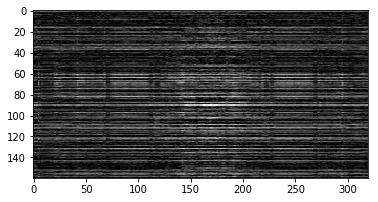

In [6]:
# Plot Measurements

print(measurement_var.shape)
plt.imshow(measurement_var, cmap = 'gray')
plt.show()

In [7]:
# Analyze why phase retrieval (approx. =) lin. comp. sensing

print(measurement_var)

tensor([[ 5.7698e+00,  5.9317e+00,  5.5195e+00,  ...,  4.4143e+00,
          3.8722e+00,  4.1294e+00],
        [ 3.9512e+00,  3.5223e+00,  3.2648e+00,  ...,  2.9259e+00,
          2.6845e+00,  2.4395e+00],
        [ 7.9128e-01,  8.0085e-01,  1.1479e+00,  ...,  2.5596e-02,
          2.3254e-01,  4.5437e-01],
        ...,
        [ 1.2017e+00,  1.4820e+00,  1.0654e+00,  ...,  7.6840e-01,
          3.8752e-01,  5.6687e-01],
        [ 1.2162e+00,  1.1082e+00,  1.7994e+00,  ...,  2.6160e+00,
          3.3740e+00,  2.5856e+00],
        [ 7.3880e-02,  1.9294e-01,  4.2279e-01,  ...,  2.1809e-01,
          6.2704e-02,  1.7296e-01]], device='cuda:0')


In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
num_iter = 1300

In [ ]:
# Load Previous Data
filename = "./plots/lin_comp_sense/" + "losses.obj"
with open (filename, 'rb') as fp:
    losses_normal = pickle.load(fp)
filename = "./plots/phase_retrieval/" + "losses_abs.obj"
with open (filename, 'rb') as fp:
    losses_abs = pickle.load(fp)

# Plot Losses simultaneously

plt.plot(np.arange(1,num_iter+1),losses_normal)
plt.plot(np.arange(1,num_iter+1),losses_abs)

import matplotlib.patches as mpatches
directory = "./plots/"
orange_patch = mpatches.Patch(color='blue', label='y = A*x')
blue_patch = mpatches.Patch(color='orange', label='y = |A*x|')
plt.legend(handles=[orange_patch,blue_patch])
plt.xlabel('iteration')
plt.ylabel('avg. |A*net_out-B**(A*image)|l2')
plt.savefig(directory+'loss vs iteration')

plt.show()